# Importazione librerie utili

In [27]:
import pandas as pd
import matplotlib as plm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
import seaborn as sns
import numpy as np
from numpy import median
from seaborn import JointGrid

# Cleaning e manipolazione dataset

Al fine di realizzare la nostra visualizzazione, andiamo a manipolare il dataset per renderlo comodo all'uso:

Leggo il dataset:

In [36]:
df = pd.read_csv('compitino_dataviz_2021_2022.csv')

Divido righe MentalScore e PhisicalScore:

In [37]:
physical = df[df['nome_modulistica'] == 'SF12 PhysicalScore'].reset_index()
physical = physical.rename(columns = {'score_preop':'physical_score_preop', 'score_postop':'physical_score_postop'})
mental = df[df['nome_modulistica'] == 'SF12 MentalScore'].reset_index()
mental = mental.rename(columns = {'score_preop':'mental_score_preop', 'score_postop':'mental_score_postop'})

Unisco in un unico dataset, generando degli attributi relativi al singolo score:

In [38]:
df1 = pd.concat([physical, mental[['mental_score_preop', 'mental_score_postop']]], axis = 1)
df1.drop('index', axis = 1, inplace = True)
df1.drop('nome_modulistica', axis = 1, inplace = True)
columns_names = ['physical_score_preop',
 'physical_score_postop', 
 'mental_score_preop',
 'mental_score_postop',
 'condizioni_meteo',
 'sesso',
 'anni_ricovero',
 'temperatura_media',
 'umidita_media',
 'HI > 27',
 'natural_light']
df1 = df1.reindex(columns=columns_names)

Converto le colonne delle variabili categoriche da stringhe a fattori:

In [39]:
df1['condizioni_meteo'] = df1['condizioni_meteo'].astype("category")
df1['sesso'] = df1['sesso'].astype("category")

# Visualizzazione

Controllo le `condizioni_meteo` che presentano più di 30 osservazioni:

In [40]:
df1.groupby('condizioni_meteo').size()

condizioni_meteo
coperto                               5
nebbia                                7
nebbia al mattino                   151
neve                                  4
neve debole                           1
neve e schiarite                      4
nubi sparse                          35
pioggia                               7
pioggia debole                       47
pioggia e schiarite                 175
pioggia mista a neve e schiarite      1
poco nuvoloso                       334
sereno                              217
sole e caldo                         49
temporale e schiarite                18
dtype: int64

Riduciamo il numero di categorie, mantenendo solo quelle con una numerosità superiore a 30:

In [34]:
condizioni_meteo_numerosità_sufficiente = ['nebbia al mattino', 'nubi sparse', 'pioggia debole', 'pioggia e schiarite', \
                                          'poco nuvoloso', 'sereno', 'sole e caldo']
df1_significativo = df1[df1['condizioni_meteo'].isin(condizioni_meteo_numerosità_sufficiente)]
df1_significativo["condizioni_meteo"] = df1_significativo["condizioni_meteo"].cat.remove_unused_categories()

C:\Users\cafe6\AppData\Local\Temp/ipykernel_18420/1025064578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_significativo["condizioni_meteo"] = df1_significativo["condizioni_meteo"].cat.remove_unused_categories()


Calcoliamo i valori utili di umidità rispetto alle categorie considerate:

In [41]:
umid = df1_significativo.groupby('condizioni_meteo')['umidita_media'].agg(['count', 'std', 'mean'])

#INTERVALLO DI CONFIDENZA
z = 1.96 #corrisponde a confidenza 95%

umid['mean_conf_interv'] = 2 * z * umid['std'] / umid['count']**(1/2)
umid['mean_conf_inf'] = umid['mean'] - z * umid['std'] / umid['count']**(1/2)
umid['mean_conf_sup'] = umid['mean'] + z * umid['std'] / umid['count']**(1/2)

umid

,count,std,mean,mean_conf_interv,mean_conf_inf,mean_conf_sup
condizioni_meteo,,,,,,
nebbia al mattino,151,11.125946,82.000000,3.549233,80.225383,83.774617
nubi sparse,35,15.184136,77.828571,10.061023,72.798060,82.859083
pioggia debole,47,7.821139,93.297872,4.472055,91.061845,95.533900
pioggia e schiarite,175,9.576500,85.142857,2.837748,83.723983,86.561731
poco nuvoloso,334,12.276168,66.446108,2.633150,65.129533,67.762683
sereno,217,13.512337,59.152074,3.595727,57.354210,60.949937
sole e caldo,49,5.668267,58.469388,3.174230,56.882273,60.056503


Creiamo la visualizzazione:

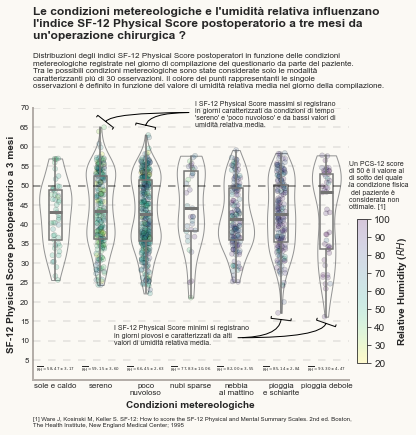

In [42]:
sns.set_style('white')

#Setting parametri utili
my_dpi = 300
fig, ax = plt.subplots(figsize= (1700/my_dpi, 1500/my_dpi))
fig.patch.set_facecolor('#fbf9f4')
ax.set_facecolor('#fbf9f4')
color_scale = ["#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3", "#7570B3"]
linee_orizzontali = list(range(5, 75, 5))
    
BOX_PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'#747473', 'zorder': 2, 'linewidth': 1.5},
    'whiskerprops':{'color':'#747473', 'linewidth':1.5},
    'medianprops':{'linewidth':'3', 'color':'#747473', 'solid_capstyle':'butt'},
    'meanprops':{"marker":"o","markerfacecolor":"#850e00", "markeredgecolor":"#850e00", 'zorder':3}
}

#Creazione violin plots
sns.violinplot(data=df1_significativo, x='condizioni_meteo', y='physical_score_postop',
                    order=['sole e caldo', 'sereno', 'poco nuvoloso', 'nubi sparse', 'nebbia al mattino', 'pioggia e schiarite', 
                    'pioggia debole'], \
                    linewidth=1, \
                    inner = None, \
                    color = '#fbf9f4', \
                    scale = 'area', \
                    cut = 0, \
                    alpha = 1, \
                    zorder = 0,\
                    ax = ax)
 
#Sovrapposizione box plots
sns.boxplot(x = 'condizioni_meteo', y = 'physical_score_postop', data = df1_significativo, \
            order=['sole e caldo', 'sereno', 'poco nuvoloso', 'nubi sparse', 'nebbia al mattino', 'pioggia e schiarite', 
                    'pioggia debole'], \
            width = 0.3, \
            showcaps = False,\
            ax = ax,\
            #showmeans = True, \
            **BOX_PROPS)

#Sovrapposizione strip plots, con colore dei punti dipendente dal valore di umidità media
stripplot = sns.stripplot(x = 'condizioni_meteo', y = 'physical_score_postop', hue = 'umidita_media', data = df1_significativo,
                      order=['sole e caldo', 'sereno', 'poco nuvoloso', 'nubi sparse', 'nebbia al mattino', 'pioggia e schiarite', 
                             'pioggia debole'],
                      palette = "viridis_r", \
                      edgecolor = "k", \
                      jitter = True, \
                      alpha = 0.2, \
                      linewidth = 0.5, \
                      s = 5,
                      zorder = 1,
                      ax = ax)

#Non vogliamo la legenda, che viene rimossa
plt.legend([],[], frameon=False)

#Disegno delle linee in background 
for h in linee_orizzontali:
    if h == 50:
        ax.axhline(50, color='k', ls=(0, (5, 5)), alpha=0.5, zorder=6)
    else:
        ax.axhline(h, color='#7F7F7F', ls=(0, (5, 5)), alpha=0.2, zorder=5)
        
#Contorno grafico
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.spines["left"].set_color('#b4aea9')
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color('#b4aea9')
ax.spines["bottom"].set_linewidth(2)

#Personalizzazione degli assi (nomi e ticks)
ax.tick_params(length=0)
ax.set_ylim(0,70)
ax.set_yticks(linee_orizzontali)
ax.set_yticklabels(linee_orizzontali, size=8)
y_label = "SF-12 Physical Score postoperatorio a 3 mesi"
ax.set_ylabel(y_label, size=10, weight="bold")
ax.set_xlabel("Condizioni metereologiche", size=10, weight="bold", labelpad = 5)
xlabels = ['sole e caldo', 'sereno', 'poco\nnuvoloso', 'nubi sparse','nebbia\nal mattino', 'pioggia\ne schiarite', 'pioggia debole']
ax.set_xticklabels(xlabels, size=8, ha="center", ma="center")

#Inserimento del titolo
titolo = "Le condizioni metereologiche e l'umidità relativa influenzano\nl'indice SF-12 Physical Score postoperatorio a tre mesi da\nun'operazione chirurgica ?"
fig.suptitle(
    titolo,
    x = 0.125,
    y = 1.16,
    ha="left",
    fontsize=12,
    weight="bold",
    wrap = True
)

#Inserimento del sottotitolo
sottotitolo = "Distribuzioni degli indici SF-12 Physical Score postoperatori in funzione delle condizioni\nmetereologiche registrate nel giorno di compilazione del questionario da parte del paziente.\nTra le possibili condizioni metereologiche sono state considerate solo le modalità\ncaratterizzanti più di 30 osservazioni. Il colore dei punti rappresentanti le singole\nosservazioni è definito in funzione del valore di umidità relativa media nel giorno della compilazione."
ax.set_title(sottotitolo, loc='left', pad=20, fontsize=8)

#Inserimento valori di umidità media con rispettivi intervalli di confidenza
ax.text(0, 2.5, r'$\overline{RH}=58,47 \pm 3,17$', fontsize=4, va="center", ha="center") 
ax.text(1, 2.5, r'$\overline{RH}=59,15 \pm 3,60$', fontsize=4, va="center", ha="center") 
ax.text(2, 2.5, r'$\overline{RH}=66,45 \pm 2,63$', fontsize=4, va="center", ha="center")
ax.text(3, 2.5, r'$\overline{RH}=77,83 \pm 10,06$',fontsize=4, va="center", ha="center")
ax.text(4, 2.5, r'$\overline{RH}=82,00 \pm 3,55$', fontsize=4, va="center", ha="center")
ax.text(5, 2.5, r'$\overline{RH}=85,14 \pm 2,84$', fontsize=4, va="center", ha="center") 
ax.text(6, 2.5, r'$\overline{RH}=93,30 \pm 4,47$', fontsize=4, va="center", ha="center")

#Aggiunta e personalizzazione della colorbar
cbar_ax = fig.add_axes([0.92, 0.17, 0.025, 0.4])

norm = plt.Normalize(20, 100)

cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="viridis_r"), 
    cax=cbar_ax,
    orientation = "vertical",
    ticks = [20,30,40,50,60,70,80,90,100],
    alpha = 0.22
)
cb.set_label("Relative Humidity (${RH}$)", size=10, weight="bold")

#Inserimento del context
#Annotazioni all'interno del grafico
label1 = "I SF-12 Physical Score minimi si registrano\nin giorni piovosi e caratterizzati da alti\nvalori di umidità relativa media."

ax.text(1.3, 9 - pad, label1, fontsize=7, va="bottom", ha="left") 
ax.annotate('', xy=(5, 16), xytext=(4, 11 - pad), 
            arrowprops=dict(arrowstyle="-[", 
                            connectionstyle="angle3,angleA=0,angleB=-90",
                            color = 'k'))
ax.annotate('', xy=(6, 15), xytext=(4.1, 11 - pad), 
            arrowprops=dict(arrowstyle="-[", 
                            connectionstyle="angle3,angleA=0,angleB=-90",
                            color = 'k'))

label2 = "I SF-12 Physical Score massimi si registrano\nin giorni caratterizzati da condizioni di tempo\n'sereno' e 'poco nuvoloso' e da bassi valori di\numidità relativa media."

ax.text(3.1, 65 - pad, label2, fontsize=7, va="bottom", ha="left") 
ax.annotate('', xy=(1.1, 66), xytext=(3, 69 - pad), 
            arrowprops=dict(arrowstyle="-[", 
                            connectionstyle="angle3,angleA=0,angleB=-90",
                            color = 'k'))
ax.annotate('', xy=(2, 65), xytext=(3, 69 - pad), 
            arrowprops=dict(arrowstyle="-[", 
                            connectionstyle="angle3,angleA=0,angleB=-90",
                            color = 'k'))
#Annotazione asse 50 e aggiunta della fonte
label3 = ("Un PCS-12 score\ndi 50 è il valore al\ndi sotto del quale\nla condizione fisica\n del paziente è\nconsiderata non\nottimale. [1]")
label4 = "[1] Ware J, Kosinski M, Keller S. SF-12: How to score the SF-12 Physical and Mental Summary Scales. 2nd ed. Boston,\nThe Health Institute, New England Medical Center; 1995"

pad = 0.2 
ax.text(6.5, 50, label3, fontsize=7, va="center", ha="left")
ax.text(-0.5, -11, label4, fontsize=6, va="center", ha="left")

#Opzioni di salvataggio
fig.savefig("compitino_primaviz", dpi=300, bbox_inches='tight')